# A guide on good usage of non_blocking and pin_memory() in PyTorch

## Introduction

Transferring data from the CPU to the GPU is fundamental in many PyTorch applications. It’s crucial for users to understand the most effective tools and options available for moving data between devices. This tutorial examines two key methods for device-to-device data transfer in PyTorch: pin_memory() and to() with the non_blocking=True option.

## what you will learn

Optimizing the transfer of tensors from the CPU to the GPU can be achieved through asynchronous transfers and memory pinning. However, there are important considerations:

Using tensor.pin_memory().to(device, non_blocking=True) can be up to twice as slow as a straightforward tensor.to(device).

Generally, tensor.to(device, non_blocking=True) is an effective choice for enhancing transfer speed.

While cpu_tensor.to("cuda", non_blocking=True).mean() executes correctly, attempting cuda_tensor.to("cpu", non_blocking=True).mean() will result in erroneous outputs.

## preamble

The performance reported in this tutorial are conditioned on the system used to build the tutorial. Although the conclusions are applicable across different systems, the specific observations may vary slightly depending on the hardware available, especially on older hardware. The primary objective of this tutorial is to offer a theoretical framework for understanding CPU to GPU data transfers. However, any design decisions should be tailored to individual cases and guided by benchmarked throughput measurements, as well as the specific requirements of the task at hand.


In [ ]:
import torch

assert torch.cuda.is_available(), "A cuda device is required to run this tutorial"

This tutorial requires tensordict to be installed. If you don’t have tensordict in your environment yet, install it by running the following command in a separate cell:

In [1]:
# Install tensordict with the following command
!pip3 install tensordict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.6/651.6 kB 11.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 16.0 MB/s eta 0:00:00


We start by outlining the theory surrounding these concepts, and then move to concrete test examples of the features.

## Background

### Memory management basics

When one creates a CPU tensor in PyTorch, the content of this tensor needs to be placed in memory. The memory we talk about here is a rather complex concept worth looking at carefully. We distinguish two types of memory that are handled by the Memory Management Unit: the RAM (for simplicity) and the swap space on disk (which may or may not be the hard drive). Together, the available space in disk and RAM (physical memory) make up the virtual memory, which is an abstraction of the total resources available. In short, the virtual memory makes it so that the available space is larger than what can be found on RAM in isolation and creates the illusion that the main memory is larger than it actually is.

In normal circumstances, a regular CPU tensor is pageable which means that it is divided in blocks called pages that can live anywhere in the virtual memory (both in RAM or on disk). As mentioned earlier, this has the advantage that the memory seems larger than what the main memory actually is.

Typically, when a program accesses a page that is not in RAM, a “page fault” occurs and the operating system (OS) then brings back this page into RAM (“swap in” or “page in”). In turn, the OS may have to swap out (or “page out”) another page to make room for the new page.

In contrast to pageable memory, a pinned (or page-locked or non-pageable) memory is a type of memory that cannot be swapped out to disk. It allows for faster and more predictable access times, but has the downside that it is more limited than the pageable memory (aka the main memory).

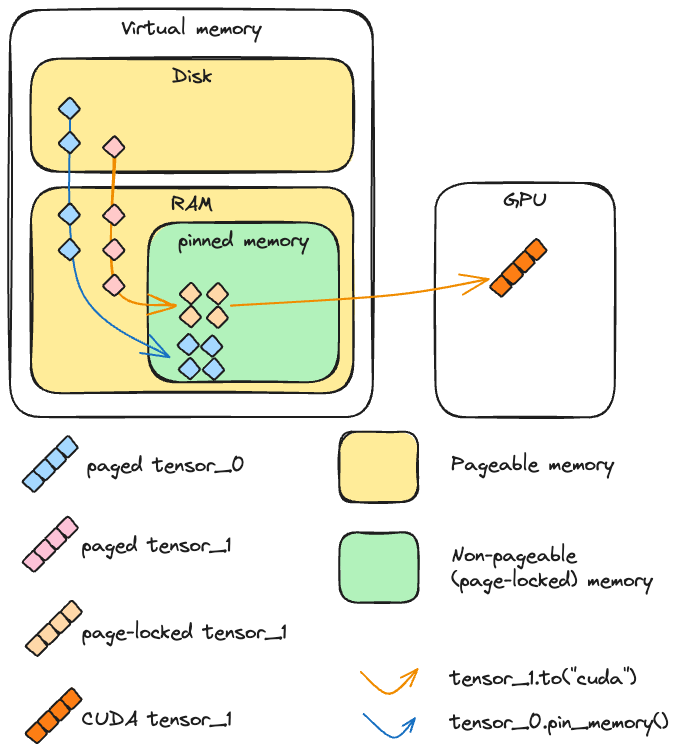

### CUDA and (non-)pageable memory

To understand how CUDA copies a tensor from CPU to CUDA, let’s consider the two scenarios above:

If the memory is page-locked, the device can access the memory directly in the main memory. The memory addresses are well defined and functions that need to read these data can be significantly accelerated.

If the memory is pageable, all the pages will have to be brought to the main memory before being sent to the GPU. This operation may take time and is less predictable than when executed on page-locked tensors.

More precisely, when CUDA sends pageable data from CPU to GPU, it must first create a page-locked copy of that data before making the transfer.

### Asynchronous vs. Synchronous Operations with non_blocking=True (CUDA cudaMemcpyAsync)

When executing a copy from a host (such as, CPU) to a device (such as, GPU), the CUDA toolkit offers modalities to do these operations synchronously or asynchronously with respect to the host.

In practice, when calling to(), PyTorch always makes a call to cudaMemcpyAsync. If non_blocking=False (default), a cudaStreamSynchronize will be called after each and every cudaMemcpyAsync, making the call to to() blocking in the main thread. If non_blocking=True, no synchronization is triggered, and the main thread on the host is not blocked. Therefore, from the host perspective, multiple tensors can be sent to the device simultaneously, as the thread does not need to wait for one transfer to be completed to initiate the other.

In general, the transfer is blocking on the device side (even if it isn’t on the host side): the copy on the device cannot occur while another operation is being executed. However, in some advanced scenarios, a copy and a kernel execution can be done simultaneously on the GPU side. As the following example will show, three requirements must be met to enable this:

The device must have at least one free DMA (Direct Memory Access) engine. Modern GPU architectures such as Volterra, Tesla, or H100 devices have more than one DMA engine.

The transfer must be done on a separate, non-default cuda stream. In PyTorch, cuda streams can be handles using Stream.

The source data must be in pinned memory.

We demonstrate this by running profiles on the following script.

In [ ]:
import contextlib

from torch.cuda import Stream


s = Stream()

torch.manual_seed(42)
t1_cpu_pinned = torch.randn(1024**2 * 5, pin_memory=True)
t2_cpu_paged = torch.randn(1024**2 * 5, pin_memory=False)
t3_cuda = torch.randn(1024**2 * 5, device="cuda:0")

assert torch.cuda.is_available()
device = torch.device("cuda", torch.cuda.current_device())


# The function we want to profile
def inner(pinned: bool, streamed: bool):
    with torch.cuda.stream(s) if streamed else contextlib.nullcontext():
        if pinned:
            t1_cuda = t1_cpu_pinned.to(device, non_blocking=True)
        else:
            t2_cuda = t2_cpu_paged.to(device, non_blocking=True)
        t_star_cuda_h2d_event = s.record_event()
    # This operation can be executed during the CPU to GPU copy if and only if the tensor is pinned and the copy is
    #  done in the other stream
    t3_cuda_mul = t3_cuda * t3_cuda * t3_cuda
    t3_cuda_h2d_event = torch.cuda.current_stream().record_event()
    t_star_cuda_h2d_event.synchronize()
    t3_cuda_h2d_event.synchronize()


# Our profiler: profiles the `inner` function and stores the results in a .json file
def benchmark_with_profiler(
    pinned,
    streamed,
) -> None:
    torch._C._profiler._set_cuda_sync_enabled_val(True)
    wait, warmup, active = 1, 1, 2
    num_steps = wait + warmup + active
    rank = 0
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=wait, warmup=warmup, active=active, repeat=1, skip_first=1
        ),
    ) as prof:
        for step_idx in range(1, num_steps + 1):
            inner(streamed=streamed, pinned=pinned)
            if rank is None or rank == 0:
                prof.step()
    prof.export_chrome_trace(f"trace_streamed{int(streamed)}_pinned{int(pinned)}.json")


Loading these profile traces in chrome (chrome://tracing) shows the following results: first, let’s see what happens if both the arithmetic operation on t3_cuda is executed after the pageable tensor is sent to GPU in the main stream:



In [ ]:
benchmark_with_profiler(streamed=False, pinned=False)

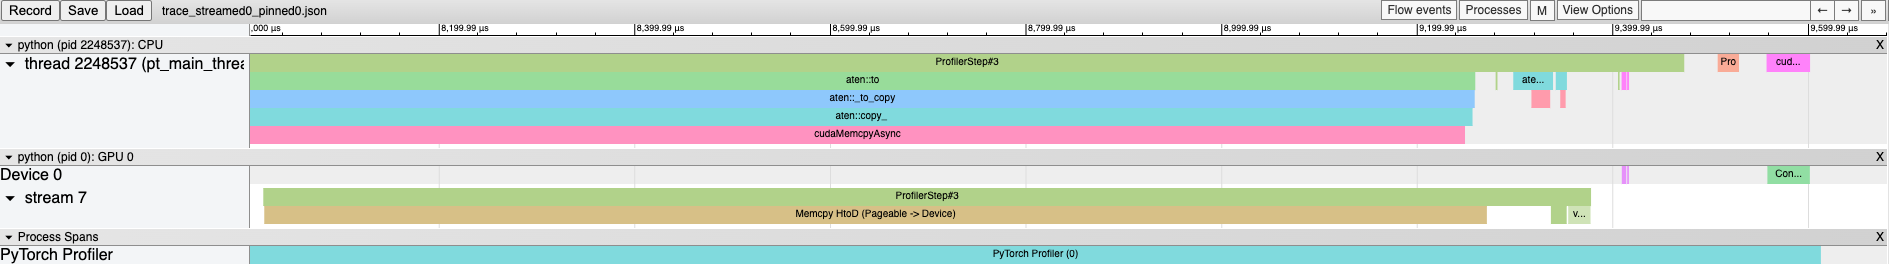

Using a pinned tensor doesn’t change the trace much, both operations are still executed consecutively:

In [ ]:
benchmark_with_profiler(streamed=False, pinned=True)

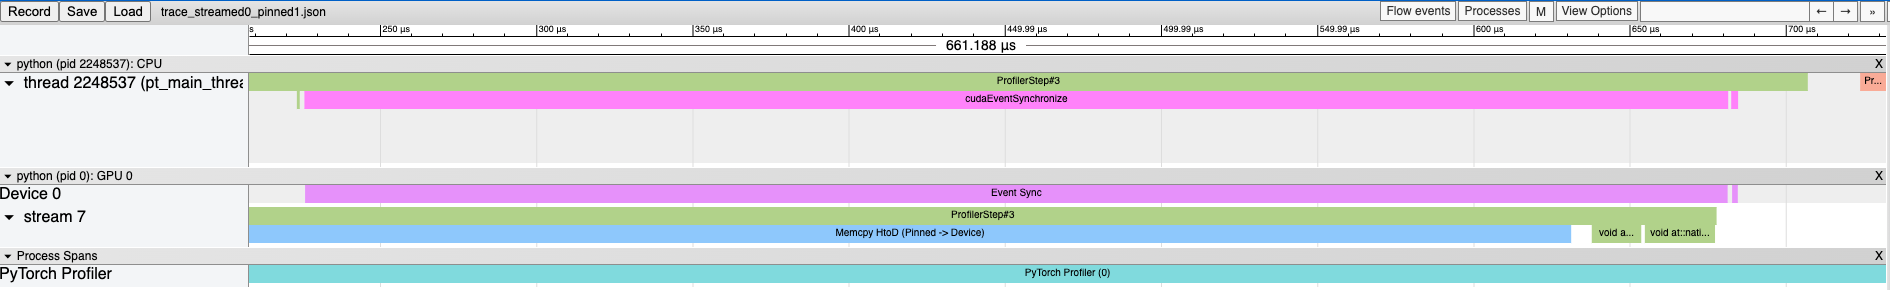

Sending a pageable tensor to GPU on a separate stream is also a blocking operation:



In [ ]:
benchmark_with_profiler(streamed=True, pinned=False)

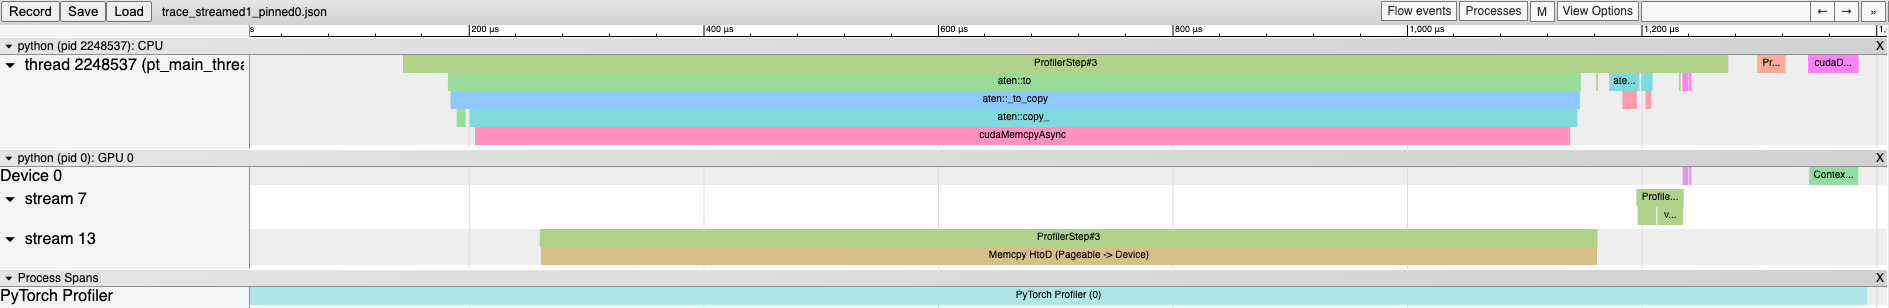

Only pinned tensors copies to GPU on a separate stream overlap with another cuda kernel executed on the main stream:

In [ ]:
benchmark_with_profiler(streamed=True, pinned=True)

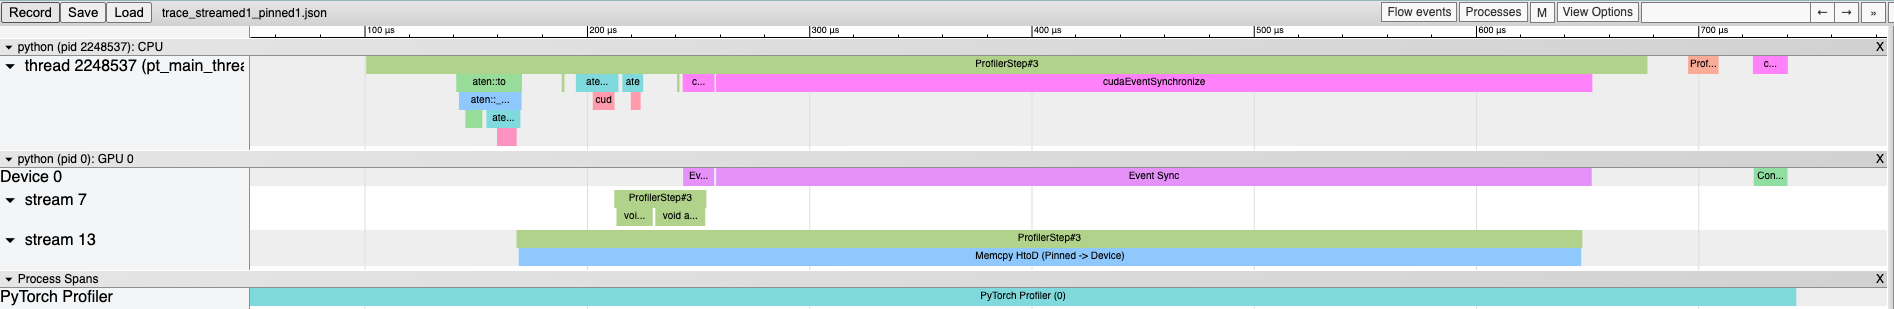

## a PyTorch perspective

### pin_memory()

PyTorch offers the possibility to create and send tensors to page-locked memory through the pin_memory() method and constructor arguments. CPU tensors on a machine where CUDA is initialized can be cast to pinned memory through the pin_memory() method. Importantly, pin_memory is blocking on the main thread of the host: it will wait for the tensor to be copied to page-locked memory before executing the next operation. New tensors can be directly created in pinned memory with functions like zeros(), ones() and other constructors.

Let us check the speed of pinning memory and sending tensors to CUDA:

In [ ]:
|import torch
import gc
from torch.utils.benchmark import Timer
import matplotlib.pyplot as plt


def timer(cmd):
    median = (
        Timer(cmd, globals=globals())
        .adaptive_autorange(min_run_time=1.0, max_run_time=20.0)
        .median
        * 1000
    )
    print(f"{cmd}: {median: 4.4f} ms")
    return median


# A tensor in pageable memory
pageable_tensor = torch.randn(1_000_000)

# A tensor in page-locked (pinned) memory
pinned_tensor = torch.randn(1_000_000, pin_memory=True)

# Runtimes:
pageable_to_device = timer("pageable_tensor.to('cuda:0')")
pinned_to_device = timer("pinned_tensor.to('cuda:0')")
pin_mem = timer("pageable_tensor.pin_memory()")
pin_mem_to_device = timer("pageable_tensor.pin_memory().to('cuda:0')")

# Ratios:
r1 = pinned_to_device / pageable_to_device
r2 = pin_mem_to_device / pageable_to_device

# Create a figure with the results
fig, ax = plt.subplots()

xlabels = [0, 1, 2]
bar_labels = [
    "pageable_tensor.to(device) (1x)",
    f"pinned_tensor.to(device) ({r1:4.2f}x)",
    f"pageable_tensor.pin_memory().to(device) ({r2:4.2f}x)"
    f"\npin_memory()={100*pin_mem/pin_mem_to_device:.2f}% of runtime.",
]
values = [pageable_to_device, pinned_to_device, pin_mem_to_device]
colors = ["tab:blue", "tab:red", "tab:orange"]
ax.bar(xlabels, values, label=bar_labels, color=colors)

ax.set_ylabel("Runtime (ms)")
ax.set_title("Device casting runtime (pin-memory)")
ax.set_xticks([])
ax.legend()

plt.show()

# Clear tensors
del pageable_tensor, pinned_tensor
_ = gc.collect()

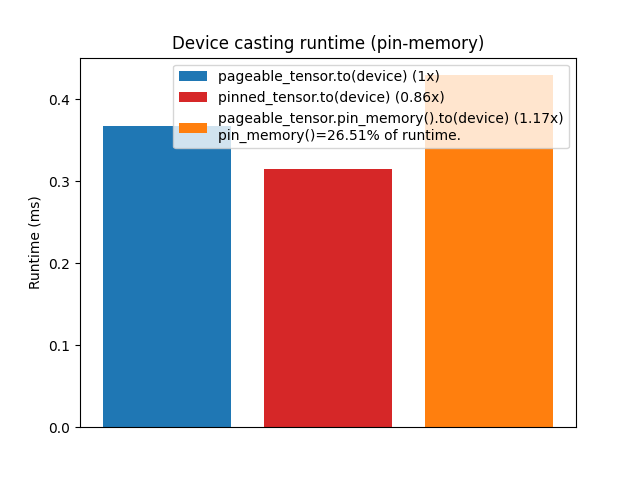

output:

pageable_tensor.to('cuda:0'):  0.3672 ms
pinned_tensor.to('cuda:0'):  0.3142 ms
pageable_tensor.pin_memory():  0.1137 ms
pageable_tensor.pin_memory().to('cuda:0'):  0.4291 ms

We can observe that casting a pinned-memory tensor to GPU is indeed much faster than a pageable tensor, because under the hood, a pageable tensor must be copied to pinned memory before being sent to GPU.

However, contrary to a somewhat common belief, calling pin_memory() on a pageable tensor before casting it to GPU should not bring any significant speed-up, on the contrary this call is usually slower than just executing the transfer. This makes sense, since we’re actually asking Python to execute an operation that CUDA will perform anyway before copying the data from host to device.

The PyTorch implementation of pin_memory which relies on creating a brand new storage in pinned memory through cudaHostAlloc could be, in rare cases, faster than transitioning data in chunks as cudaMemcpy does. Here too, the observation may vary depending on the available hardware, the size of the tensors being sent or the amount of available RAM.

## non_blocking=True

As mentioned earlier, many PyTorch operations have the option of being executed asynchronously with respect to the host through the non_blocking argument.

Here, to account accurately of the benefits of using non_blocking, we will design a slightly more complex experiment since we want to assess how fast it is to send multiple tensors to GPU with and without calling non_blocking.



In [ ]:
# A simple loop that copies all tensors to cuda
def copy_to_device(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.to("cuda:0"))
    return result


# A loop that copies all tensors to cuda asynchronously
def copy_to_device_nonblocking(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.to("cuda:0", non_blocking=True))
    # We need to synchronize
    torch.cuda.synchronize()
    return result


# Create a list of tensors
tensors = [torch.randn(1000) for _ in range(1000)]
to_device = timer("copy_to_device(*tensors)")
to_device_nonblocking = timer("copy_to_device_nonblocking(*tensors)")

# Ratio
r1 = to_device_nonblocking / to_device

# Plot the results
fig, ax = plt.subplots()

xlabels = [0, 1]
bar_labels = [f"to(device) (1x)", f"to(device, non_blocking=True) ({r1:4.2f}x)"]
colors = ["tab:blue", "tab:red"]
values = [to_device, to_device_nonblocking]

ax.bar(xlabels, values, label=bar_labels, color=colors)

ax.set_ylabel("Runtime (ms)")
ax.set_title("Device casting runtime (non-blocking)")
ax.set_xticks([])
ax.legend()

plt.show()

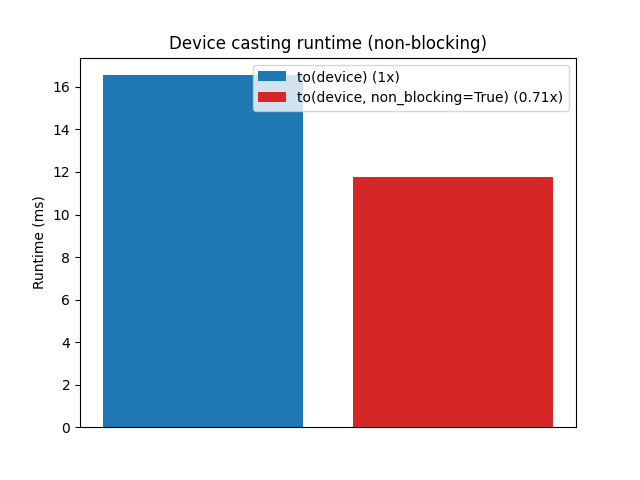

copy_to_device(*tensors):  16.5502 ms
copy_to_device_nonblocking(*tensors):  11.7725 ms

To get a better sense of what is happening here, let us profile these two functions:


In [ ]:
from torch.profiler import profile, ProfilerActivity


def profile_mem(cmd):
    with profile(activities=[ProfilerActivity.CPU]) as prof:
        exec(cmd)
    print(cmd)
    print(prof.key_averages().table(row_limit=10))

Let’s see the call stack with a regular to(device) first:

copy_to_device(*tensors)
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------
                 aten::to         3.68%     733.202us       100.00%      19.921ms      19.921us          1000
           aten::_to_copy        11.10%       2.212ms        96.32%      19.188ms      19.188us          1000
      aten::empty_strided        20.48%       4.079ms        20.48%       4.079ms       4.079us          1000
              aten::copy_        22.07%       4.396ms        64.74%      12.897ms      12.897us          1000
          cudaMemcpyAsync        17.84%       3.554ms        17.84%       3.554ms       3.554us          1000
    cudaStreamSynchronize        24.83%       4.947ms        24.83%       4.947ms       4.947us          1000
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------
Self CPU time total: 19.921ms

Call to `to(device)` None

and now the non_blocking version:

In [ ]:
print(
    "Call to `to(device, non_blocking=True)`",
    profile_mem("copy_to_device_nonblocking(*tensors)"),
)

copy_to_device_nonblocking(*tensors)
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------
                 aten::to         4.76%     724.483us        99.84%      15.181ms      15.181us          1000
           aten::_to_copy        14.55%       2.212ms        95.07%      14.456ms      14.456us          1000
      aten::empty_strided        25.62%       3.896ms        25.62%       3.896ms       3.896us          1000
              aten::copy_        31.42%       4.778ms        54.90%       8.348ms       8.348us          1000
          cudaMemcpyAsync        23.48%       3.571ms        23.48%       3.571ms       3.571us          1000
    cudaDeviceSynchronize         0.16%      24.830us         0.16%      24.830us      24.830us             1
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------
Self CPU time total: 15.206ms

Call to `to(device, non_blocking=True)` None

The results are without any doubt better when using non_blocking=True, as all transfers are initiated simultaneously on the host side and only one synchronization is done.

The benefit will vary depending on the number and the size of the tensors as well as depending on the hardware being used.

Note

Interestingly, the blocking to("cuda") actually performs the same asynchronous device casting operation (cudaMemcpyAsync) as the one with non_blocking=True with a synchronization point after each copy.

## Synergies

Now that we have made the point that data transfer of tensors already in pinned memory to GPU is faster than from pageable memory, and that we know that doing these transfers asynchronously is also faster than synchronously, we can benchmark combinations of these approaches. First, let’s write a couple of new functions that will call pin_memory and to(device) on each tensor:

In [ ]:
def pin_copy_to_device(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.pin_memory().to("cuda:0"))
    return result


def pin_copy_to_device_nonblocking(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.pin_memory().to("cuda:0", non_blocking=True))
    # We need to synchronize
    torch.cuda.synchronize()
    return result

The benefits of using pin_memory() are more pronounced for somewhat large batches of large tensors:

In [ ]:
tensors = [torch.randn(1_000_000) for _ in range(1000)]
page_copy = timer("copy_to_device(*tensors)")
page_copy_nb = timer("copy_to_device_nonblocking(*tensors)")

tensors_pinned = [torch.randn(1_000_000, pin_memory=True) for _ in range(1000)]
pinned_copy = timer("copy_to_device(*tensors_pinned)")
pinned_copy_nb = timer("copy_to_device_nonblocking(*tensors_pinned)")

pin_and_copy = timer("pin_copy_to_device(*tensors)")
pin_and_copy_nb = timer("pin_copy_to_device_nonblocking(*tensors)")

# Plot
strategies = ("pageable copy", "pinned copy", "pin and copy")
blocking = {
    "blocking": [page_copy, pinned_copy, pin_and_copy],
    "non-blocking": [page_copy_nb, pinned_copy_nb, pin_and_copy_nb],
}

x = torch.arange(3)
width = 0.25
multiplier = 0


fig, ax = plt.subplots(layout="constrained")

for attribute, runtimes in blocking.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, runtimes, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Runtime (ms)")
ax.set_title("Runtime (pin-mem and non-blocking)")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(strategies)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.legend(loc="upper left", ncols=3)

plt.show()

del tensors, tensors_pinned
_ = gc.collect()

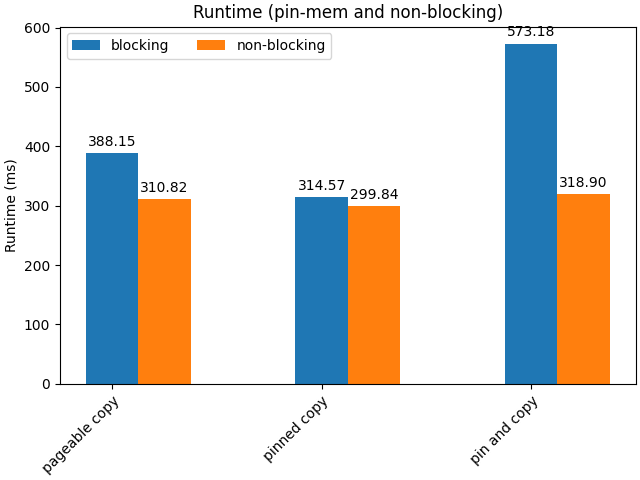

copy_to_device(*tensors):  388.1486 ms
copy_to_device_nonblocking(*tensors):  310.8198 ms
copy_to_device(*tensors_pinned):  314.5690 ms
copy_to_device_nonblocking(*tensors_pinned):  299.8428 ms
pin_copy_to_device(*tensors):  573.1812 ms
pin_copy_to_device_nonblocking(*tensors):  318.9003 ms

## Other copy directions (GPU -> CPU, CPU -> MPS)

Until now, we have operated under the assumption that asynchronous copies from the CPU to the GPU are safe. This is generally true because CUDA automatically handles synchronization to ensure that the data being accessed is valid at read time __whenever the tensor is in pageable memory__.

However, in other cases we cannot make the same assumption: when a tensor is placed in pinned memory, mutating the original copy after calling the host-to-device transfer may corrupt the data received on GPU. Similarly, when a transfer is achieved in the opposite direction, from GPU to CPU, or from any device that is not CPU or GPU to any device that is not a CUDA-handled GPU (such as, MPS), there is no guarantee that the data read on GPU is valid without explicit synchronization.

In these scenarios, these transfers offer no assurance that the copy will be complete at the time of data access. Consequently, the data on the host might be incomplete or incorrect, effectively rendering it garbage.

Let’s first demonstrate this with a pinned-memory tensor:

In [ ]:
DELAY = 100000000
try:
    i = -1
    for i in range(100):
        # Create a tensor in pin-memory
        cpu_tensor = torch.ones(1024, 1024, pin_memory=True)
        torch.cuda.synchronize()
        # Send the tensor to CUDA
        cuda_tensor = cpu_tensor.to("cuda", non_blocking=True)
        torch.cuda._sleep(DELAY)
        # Corrupt the original tensor
        cpu_tensor.zero_()
        assert (cuda_tensor == 1).all()
    print("No test failed with non_blocking and pinned tensor")
except AssertionError:
    print(f"{i}th test failed with non_blocking and pinned tensor. Skipping remaining tests")

1th test failed with non_blocking and pinned tensor. Skipping remaining tests

In [ ]:
i = -1
for i in range(100):
    # Create a tensor in pageable memory
    cpu_tensor = torch.ones(1024, 1024)
    torch.cuda.synchronize()
    # Send the tensor to CUDA
    cuda_tensor = cpu_tensor.to("cuda", non_blocking=True)
    torch.cuda._sleep(DELAY)
    # Corrupt the original tensor
    cpu_tensor.zero_()
    assert (cuda_tensor == 1).all()
print("No test failed with non_blocking and pageable tensor")

No test failed with non_blocking and pageable tensor

In [ ]:
tensor = (
    torch.arange(1, 1_000_000, dtype=torch.double, device="cuda")
    .expand(100, 999999)
    .clone()
)
torch.testing.assert_close(
    tensor.mean(), torch.tensor(500_000, dtype=torch.double, device="cuda")
), tensor.mean()
try:
    i = -1
    for i in range(100):
        cpu_tensor = tensor.to("cpu", non_blocking=True)
        torch.testing.assert_close(
            cpu_tensor.mean(), torch.tensor(500_000, dtype=torch.double)
        )
    print("No test failed with non_blocking")
except AssertionError:
    print(f"{i}th test failed with non_blocking. Skipping remaining tests")
try:
    i = -1
    for i in range(100):
        cpu_tensor = tensor.to("cpu", non_blocking=True)
        torch.cuda.synchronize()
        torch.testing.assert_close(
            cpu_tensor.mean(), torch.tensor(500_000, dtype=torch.double)
        )
    print("No test failed with synchronize")
except AssertionError:
    print(f"One test failed with synchronize: {i}th assertion!")

0th test failed with non_blocking. Skipping remaining tests
No test failed with synchronize

Generally, asynchronous copies to a device are safe without explicit synchronization only when the target is a CUDA-enabled device and the original tensor is in pageable memory.

In summary, copying data from CPU to GPU is safe when using non_blocking=True, but for any other direction, non_blocking=True can still be used but the user must make sure that a device synchronization is executed before the data is accessed.

## Practical recommendations

We can now wrap up some early recommendations based on our observations:

In general, non_blocking=True will provide good throughput, regardless of whether the original tensor is or isn’t in pinned memory. If the tensor is already in pinned memory, the transfer can be accelerated, but sending it to pin memory manually from python main thread is a blocking operation on the host, and hence will annihilate much of the benefit of using non_blocking=True (as CUDA does the pin_memory transfer anyway).

One might now legitimately ask what use there is for the pin_memory() method. In the following section, we will explore further how this can be used to accelerate the data transfer even more.

## Additional considerations

PyTorch notoriously provides a DataLoader class whose constructor accepts a pin_memory argument. Considering our previous discussion on pin_memory, you might wonder how the DataLoader manages to accelerate data transfers if memory pinning is inherently blocking.

The key lies in the DataLoader’s use of a separate thread to handle the transfer of data from pageable to pinned memory, thus preventing any blockage in the main thread.

To illustrate this, we will use the TensorDict primitive from the homonymous library. When invoking to(), the default behavior is to send tensors to the device asynchronously, followed by a single call to torch.device.synchronize() afterwards.

Additionally, TensorDict.to() includes a non_blocking_pin option which initiates multiple threads to execute pin_memory() before proceeding with to to(device). This approach can further accelerate data transfers, as demonstrated in the following example.

In [ ]:
from tensordict import TensorDict
import torch
from torch.utils.benchmark import Timer
import matplotlib.pyplot as plt

# Create the dataset
td = TensorDict({str(i): torch.randn(1_000_000) for i in range(1000)})

# Runtimes
copy_blocking = timer("td.to('cuda:0', non_blocking=False)")
copy_non_blocking = timer("td.to('cuda:0')")
copy_pin_nb = timer("td.to('cuda:0', non_blocking_pin=True, num_threads=0)")
copy_pin_multithread_nb = timer("td.to('cuda:0', non_blocking_pin=True, num_threads=4)")

# Rations
r1 = copy_non_blocking / copy_blocking
r2 = copy_pin_nb / copy_blocking
r3 = copy_pin_multithread_nb / copy_blocking

# Figure
fig, ax = plt.subplots()

xlabels = [0, 1, 2, 3]
bar_labels = [
    "Blocking copy (1x)",
    f"Non-blocking copy ({r1:4.2f}x)",
    f"Blocking pin, non-blocking copy ({r2:4.2f}x)",
    f"Non-blocking pin, non-blocking copy ({r3:4.2f}x)",
]
values = [copy_blocking, copy_non_blocking, copy_pin_nb, copy_pin_multithread_nb]
colors = ["tab:blue", "tab:red", "tab:orange", "tab:green"]

ax.bar(xlabels, values, label=bar_labels, color=colors)

ax.set_ylabel("Runtime (ms)")
ax.set_title("Device casting runtime")
ax.set_xticks([])
ax.legend()

plt.show()

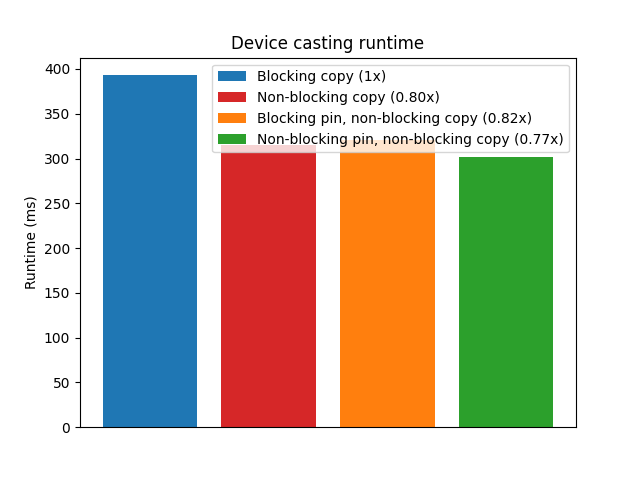

td.to('cuda:0', non_blocking=False):  393.0533 ms
td.to('cuda:0'):  314.7992 ms
td.to('cuda:0', non_blocking_pin=True, num_threads=0):  320.8332 ms
td.to('cuda:0', non_blocking_pin=True, num_threads=4):  301.2167 ms

In this example, we are transferring many large tensors from the CPU to the GPU. This scenario is ideal for utilizing multithreaded pin_memory(), which can significantly enhance performance. However, if the tensors are small, the overhead associated with multithreading may outweigh the benefits. Similarly, if there are only a few tensors, the advantages of pinning tensors on separate threads become limited.

As an additional note, while it might seem advantageous to create permanent buffers in pinned memory to shuttle tensors from pageable memory before transferring them to the GPU, this strategy does not necessarily expedite computation. The inherent bottleneck caused by copying data into pinned memory remains a limiting factor.

Moreover, transferring data that resides on disk (whether in shared memory or files) to the GPU typically requires an intermediate step of copying the data into pinned memory (located in RAM). Utilizing non_blocking for large data transfers in this context can significantly increase RAM consumption, potentially leading to adverse effects.

In practice, there is no one-size-fits-all solution. The effectiveness of using multithreaded pin_memory combined with non_blocking transfers depends on a variety of factors, including the specific system, operating system, hardware, and the nature of the tasks being executed. Here is a list of factors to check when trying to speed-up data transfers between CPU and GPU, or comparing throughput’s across scenarios:

Number of available cores

    How many CPU cores are available? Is the system shared with other users or processes that might compete for resources?

Core utilization

    Are the CPU cores heavily utilized by other processes? Does the application perform other CPU-intensive tasks concurrently with data transfers?

Memory utilization

    How much pageable and page-locked memory is currently being used? Is there sufficient free memory to allocate additional pinned memory without affecting system performance? Remember that nothing comes for free, for instance pin_memory will consume RAM and may impact other tasks.

CUDA Device Capabilities

    Does the GPU support multiple DMA engines for concurrent data transfers? What are the specific capabilities and limitations of the CUDA device being used?

Number of tensors to be sent

    How many tensors are transferred in a typical operation?

Size of the tensors to be sent

    What is the size of the tensors being transferred? A few large tensors or many small tensors may not benefit from the same transfer program.

System Architecture

    How is the system’s architecture influencing data transfer speeds (for example, bus speeds, network latency)?

Additionally, allocating a large number of tensors or sizable tensors in pinned memory can monopolize a substantial portion of RAM. This reduces the available memory for other critical operations, such as paging, which can negatively impact the overall performance of an algorithm.

## Conclusion

Throughout this tutorial, we have explored several critical factors that influence transfer speeds and memory management when sending tensors from the host to the device. We’ve learned that using non_blocking=True generally accelerates data transfers, and that pin_memory() can also enhance performance if implemented correctly. However, these techniques require careful design and calibration to be effective.

Remember that profiling your code and keeping an eye on the memory consumption are essential to optimize resource usage and achieve the best possible performance.

